# Training Deepfake Audio Classifier 

In this notebook,, an MLP classifier is trained on the Wav2Vec embeddings extracted. 

* Loading data, defining the model, training, validation and evaluation! 

In [12]:
# install required libraries and their compatability 
!pip install --force-reinstall numpy scipy scikit-learn


  Using cached numpy-2.0.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached scipy-1.13.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached scikit_learn-1.6.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached numpy-2.0.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (19.5 MB)
Using cached scipy-1.13.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
Using cached scikit_learn-1.6.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.2.0
    Uninstalling threadpoolctl-3.2.0:
ERROR: Could not install packages 

Train: torch.Size([13612, 768]), torch.Size([13612])
Val: torch.Size([2720, 768]), torch.Size([2720])
Test: torch.Size([959, 768]), torch.Size([959])
Epoch 1/20 - Loss: 0.6942 - Val Acc: 0.6559
Epoch 2/20 - Loss: 0.6878 - Val Acc: 0.6647
Epoch 3/20 - Loss: 0.6816 - Val Acc: 0.6739
Epoch 4/20 - Loss: 0.6740 - Val Acc: 0.6772
Epoch 5/20 - Loss: 0.6652 - Val Acc: 0.6776
Epoch 6/20 - Loss: 0.6552 - Val Acc: 0.6761
Epoch 7/20 - Loss: 0.6446 - Val Acc: 0.6776
Epoch 8/20 - Loss: 0.6335 - Val Acc: 0.6813
Epoch 9/20 - Loss: 0.6224 - Val Acc: 0.6827
Epoch 10/20 - Loss: 0.6120 - Val Acc: 0.6842
Epoch 11/20 - Loss: 0.6028 - Val Acc: 0.6882
Epoch 12/20 - Loss: 0.5952 - Val Acc: 0.6908
Epoch 13/20 - Loss: 0.5895 - Val Acc: 0.6901
Epoch 14/20 - Loss: 0.5855 - Val Acc: 0.6938
Epoch 15/20 - Loss: 0.5828 - Val Acc: 0.6967
Epoch 16/20 - Loss: 0.5809 - Val Acc: 0.6993
Epoch 17/20 - Loss: 0.5787 - Val Acc: 0.7063
Epoch 18/20 - Loss: 0.5747 - Val Acc: 0.7059
Epoch 19/20 - Loss: 0.5715 - Val Acc: 0.7092
Epoc

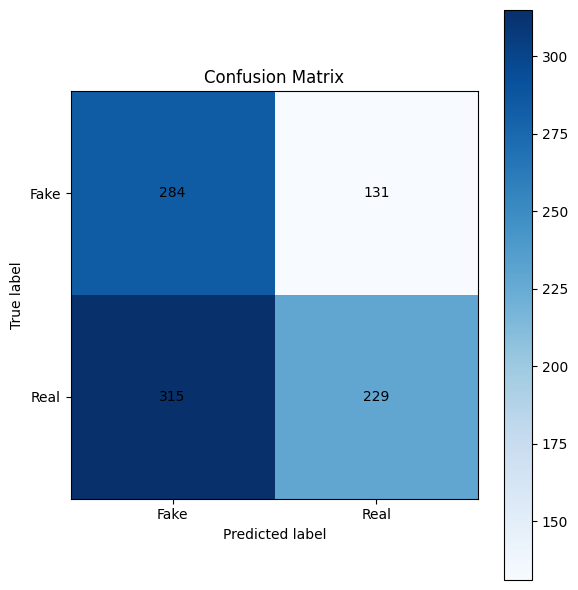

In [16]:
# imports
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# load processed embeddings - saved .pt files 

# path to saved embeddings 
EMBEDDINGS_DIR = "deepfake_audio_project/data/processed_embeddings"

# initialize lists to hold data 
X_train, y_train = [], []
X_val, y_val = [], []
X_test, y_test = [], []

# map labels to integers for classification 
lael_to_idx = {'fake': 0, 'real': 1}

# load all .pt files and split into dataset 
for file in os.listdir(EMBEDDINGS_DIR):
    if file.endswith(".pt"):
        data = torch.load(os.path.join(EMBEDDINGS_DIR, file))
        emb = data["embedding"]
        label = label_to_idx[data["label"]]
        split = data.get("split", None)

        if split is None:
            print(f"Skipping {file} (no split info)")
            continue

        if split == "training":
            X_train.append(emb)
            y_train.append(label)
        elif split == "validation":
            X_val.append(emb)
            y_val.append(label)
        elif split == "testing":
            X_test.append(emb)
            y_test.append(label)

# convert feature vectors to tensors
X_train = torch.stack(X_train)
y_train = torch.tensor(y_train)
X_val = torch.stack(X_val)
y_val = torch.tensor(y_val)
X_test = torch.stack(X_test)
y_test = torch.tensor(y_test)

# print shapes to confirm 
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val: {X_val.shape}, {y_val.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

# define MLP model - a simple 3 layer MLP for binary classification 
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256):
        super(MLPClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, 2)  # binary classification (fake or real)
        )
        
    def forward(self, x):
        return self.net(x)

# instantiate model
input_dim = X_train.shape[1] # dimension equals feature size (768 if wav2vec2)
model = MLPClassifier(input_dim).to('cuda' if torch.cuda.is_available() else 'cpu')

# set up loss function and optimizer 
# using crossentropyloss and adam 

# loss and optimizer

# loss
criterion = nn.CrossEntropyLoss()

# optimizer 
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# training loop
# training model, saving best model based on validation

# training parameters 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 20
best_val_acc = 0 # track validation accuracy 

# training loop 
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # forward pass on training data 
    outputs = model(X_train.to(device))
    loss = criterion(outputs, y_train.to(device))
    
    # backward pass + optimization
    loss.backward()
    optimizer.step()

    # validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val.to(device))
        _, val_preds = torch.max(val_outputs, 1)
        val_acc = (val_preds == y_val.to(device)).float().mean().item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f} - Val Acc: {val_acc:.4f}")

    # save best model - checkpoint 
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_mlp_model.pth")

print("Training complete!")

# load best model
model.load_state_dict(torch.load("best_mlp_model.pth"))

# testing
# final evaluation 

model.eval()
with torch.no_grad():
    test_outputs = model(X_test.to(device))
    _, test_preds = torch.max(test_outputs, 1)
    test_acc = (test_preds == y_test.to(device)).float().mean().item()
    print(f"Final Test Accuracy: {test_acc:.4f}")

    # classification metrics 
    print("\nClassification Report:")
    print(classification_report(y_test.cpu(), test_preds.cpu(), target_names=['Fake', 'Real']))

# confusion matrix 
cm = confusion_matrix(y_test.cpu(), test_preds.cpu())

plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Fake', 'Real'])
plt.yticks(tick_marks, ['Fake', 'Real'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

# adding numbers with black text for better visibility
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="black")

plt.tight_layout()
plt.show()


Extracted Wav2Vec2 embeddings (768 dimensions) for each clip and trained a basic MLP classifier.

Dataset: for-2sec (2-second audio clips)

Feature extraction: Wav2Vec2-base (facebook/wav2vec2-base-960h)

Model: 3-layer MLP (Linear -> ReLU -> Linear -> ReLU -> Linear)

Loss function: CrossEntropyLoss

Optimizer: Adam, learning rate 1e-3

Epochs: 20

Train/Validation/Test split applied properly

Device used: GPU (CUDA)

## Training Summary: 
* Training loss steadily decreased over the 20 epochs.

* Validation accuracy improved gradually, reaching approximately 70% by the end.

* No obvious signs of overfitting; training and validation performance moved together.

## Final Results for this model: 

* Final Test Accuracy: 52%

* Fake Class Precision: 46%

* Fake Class Recall: 63%

* Real Class Precision: 61%

* Real Class Recall: 44%

* Weighted F1 Score: 52%

## Observations: 

* The model was able to learn patterns but struggled to generalize to the unseen test set.

* The short 2-second clips likely limited the amount of useful information the model could leverage.

* Fake samples were detected better (higher recall for fake class) but real samples were missed more often (lower recall).

## Takeaways:
* Solid baseline established for short audio clip classification.

* Performance is reasonable considering the limited input length.

* Moving to longer, more information-rich audio clips (for-norm dataset) is the next step to improve results.

* Plan to upgrade model complexity by introducing deeper MLP architectures, Batch Normalization, and Dropout.


# Deeper MLP model:

Building on the earlier baseline by training a deeper MLP architecture on the 2 second audio embeddings. 

* Added complexity and regularization to improve generalization. 

he original shallow MLP was extended to a deeper network to give the model more representational power.

### Architecture details:

Input layer: 768-dimensional input vector.

* Hidden Layer 1:

512 units

ReLU activation

Dropout with p=0.3

* Hidden Layer 2:

256 units

ReLU activation

Dropout with p=0.3

* Hidden Layer 3:

128 units

ReLU activation

Dropout with p=0.3

* Output layer:

2 units (one for each class: Fake, Real)

#### Key points:

* Dropout is used after every hidden layer to prevent overfitting.

* ReLU activations help the model learn nonlinear patterns.

* Output is passed to a CrossEntropyLoss for binary classification.

Train: torch.Size([13612, 768]), torch.Size([13612])
Val: torch.Size([2720, 768]), torch.Size([2720])
Test: torch.Size([959, 768]), torch.Size([959])
Epoch 1/20 - Loss: 0.6960 - Val Acc: 0.4956
Epoch 2/20 - Loss: 0.6918 - Val Acc: 0.6647
Epoch 3/20 - Loss: 0.6870 - Val Acc: 0.6640
Epoch 4/20 - Loss: 0.6790 - Val Acc: 0.6787
Epoch 5/20 - Loss: 0.6670 - Val Acc: 0.6787
Epoch 6/20 - Loss: 0.6518 - Val Acc: 0.6831
Epoch 7/20 - Loss: 0.6333 - Val Acc: 0.6838
Epoch 8/20 - Loss: 0.6150 - Val Acc: 0.6875
Epoch 9/20 - Loss: 0.6044 - Val Acc: 0.6805
Epoch 10/20 - Loss: 0.6142 - Val Acc: 0.6724
Epoch 11/20 - Loss: 0.6347 - Val Acc: 0.6926
Epoch 12/20 - Loss: 0.5960 - Val Acc: 0.6813
Epoch 13/20 - Loss: 0.6149 - Val Acc: 0.6960
Epoch 14/20 - Loss: 0.5964 - Val Acc: 0.7015
Epoch 15/20 - Loss: 0.5850 - Val Acc: 0.6960
Epoch 16/20 - Loss: 0.5965 - Val Acc: 0.7022
Epoch 17/20 - Loss: 0.5844 - Val Acc: 0.7077
Epoch 18/20 - Loss: 0.5796 - Val Acc: 0.6956
Epoch 19/20 - Loss: 0.5864 - Val Acc: 0.6978
Epoc

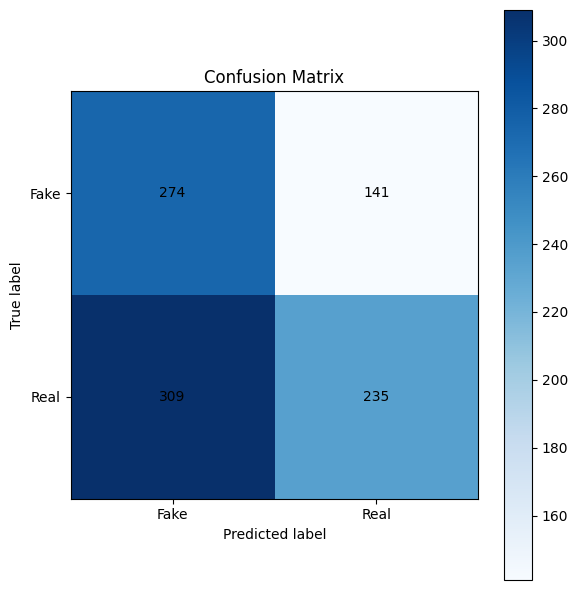

In [17]:
# imports
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# paths
EMBEDDINGS_DIR = "deepfake_audio_project/data/processed_embeddings"

# initialize empty lists to load embeddings and labels 
X_train, y_train = [], []
X_val, y_val = [], []
X_test, y_test = [], []

# label mapping
label_to_idx = {'fake': 0, 'real': 1}

# load all embeddings and corresponding labels/splits 
for file in os.listdir(EMBEDDINGS_DIR):
    if file.endswith(".pt"):
        data = torch.load(os.path.join(EMBEDDINGS_DIR, file))
        emb = data["embedding"] # extracted features
        label = label_to_idx[data["label"]] # label to integer
        split = data.get("split", None) # training, validation, testing

        # skip if info is missing
        if split is None:
            print(f"Skipping {file} (no split info)")
            continue

        # assign data to split 
        if split == "training":
            X_train.append(emb)
            y_train.append(label)
        elif split == "validation":
            X_val.append(emb)
            y_val.append(label)
        elif split == "testing":
            X_test.append(emb)
            y_test.append(label)

# single torch tensors 
X_train = torch.stack(X_train)
y_train = torch.tensor(y_train)
X_val = torch.stack(X_val)
y_val = torch.tensor(y_val)
X_test = torch.stack(X_test)
y_test = torch.tensor(y_test)

# print dataset sizes for verification
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val: {X_val.shape}, {y_val.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

# define deep MLP model - multiple hidden layers and dropout 
class DeepMLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, dropout_p=0.3):
        super(DeepMLPClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hidden_dim//2, hidden_dim//4),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(hidden_dim//4, 2)  # binary classification
        )
        
    def forward(self, x):
        return self.net(x)

# instantiate model
input_dim = X_train.shape[1] # input feature size
model = DeepMLPClassifier(input_dim).to('cuda' if torch.cuda.is_available() else 'cpu')

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 20
best_val_acc = 0

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # forward pass on training data 
    outputs = model(X_train.to(device))
    loss = criterion(outputs, y_train.to(device))
    
    # backward pass and optimization
    loss.backward()
    optimizer.step()

    # validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val.to(device))
        _, val_preds = torch.max(val_outputs, 1) 
        val_acc = (val_preds == y_val.to(device)).float().mean().item()

        # training update 
    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f} - Val Acc: {val_acc:.4f}")

    # save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_deep_mlp_model.pth")

print("Training complete!")

# load best model
model.load_state_dict(torch.load("best_deep_mlp_model.pth"))

# testing - evaluate 
model.eval()
with torch.no_grad():
    test_outputs = model(X_test.to(device))
    _, test_preds = torch.max(test_outputs, 1)
    test_acc = (test_preds == y_test.to(device)).float().mean().item()
    print(f"Final Test Accuracy: {test_acc:.4f}")

    # classification report
    print("\nClassification Report:")
    print(classification_report(y_test.cpu(), test_preds.cpu(), target_names=['Fake', 'Real']))

# confusion matrix 
cm = confusion_matrix(y_test.cpu(), test_preds.cpu())
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Fake', 'Real'])
plt.yticks(tick_marks, ['Fake', 'Real'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

# adding annotations on matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="black")

plt.tight_layout()
plt.show()


## Training Summary: 

* Training loss did decrease steadily across epochs.

* Validation accuracy gradually did improve from around 67% up to about 71%.

* it doesn't looke like major overfitting between training and validation phases occured.

## Final Test Results: 
* Final Test Accuracy: 53.6%
* Fake Class:
* Precision: 47%
* Recall: 67%
* F1-score: 56%
* Real Class:
* Precision: 63%
* Recall: 43%
* F1-score: 51%
* Overall Weighted Average F1-score: 53%

## Observations:

Validation accuracy looked relatively stable, peaking around 71%, which is a good sign of healthy training?

Test set accuracy dropped compared to validation performance, down to 53–54%, indicating generalization is still a bit of a challenge.

The model predicted fake samples with higher recall but lower precision, while real samples had better precision but lower recall.

Model performance still seems limited by the short 2-second audio clips, which restrict the amount of information available.

## Takeaways: 

* Deepening the MLP helped stabilize training and validation curves compared to a simple shallow model.

* However, it does not seem like deeper architectures alone are enough to fully overcome the limitations of the very short audio samples.

* Short 2-second segments may not capture sufficient speaker traits or synthetic audio artifacts to separate classes with high confidence.

* Input feature quality (longer audios, better feature extraction) is equally important as model size for generalization! Will be working on that next.

